Reading /home/gweindel/owncloud/projects/RUGUU/man_hmp/V2/results/replication/N2pc_data/7_reref_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     796.88 ms
        0 CTF compensation matrices available
Adding metadata with 19 columns
8 matching events found
No baseline correction applied
0 projection items activated
Processing participant N2pc_data/7_reref_epo.fif's epoched eeg
8 trials were retained for participant N2pc_data/7_reref_epo.fif
Processing participant N2pc_data/26_reref_epo.fif's epoched eeg
188 trials were retained for participant N2pc_data/26_reref_epo.fif
Processing participant N2pc_data/34_reref_epo.fif's epoched eeg
252 trials were retained for participant N2pc_data/34_reref_epo.fif
Processing participant N2pc_data/16_reref_epo.fif's epoched eeg
289 trials were retained for participant N2pc_data/16_reref_epo.fif
Processing participant N2pc_data/8_reref_epo.fif's epoched eeg
238 trials were retained for participant N2pc_data/8_reref_epo.fif
Pro

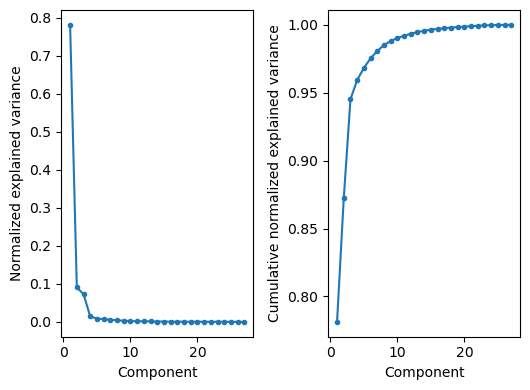

How many PCs (95 and 99% explained variance at component n4 and n10; components till n4 explain at least 1%)? 10


  0%|          | 0/144 [00:00<?, ?it/s]

Transition event 1 found around sample 32
Transition event 2 found around sample 77
Transition event 3 found around sample 128
Transition event 4 found around sample 138

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


  0%|          | 0/143 [00:00<?, ?it/s]

Transition event 1 found around sample 30
Transition event 2 found around sample 79
Transition event 3 found around sample 126
Transition event 4 found around sample 137

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


In [1]:
import os
import mne
import hmp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import bambi as bmb
import arviz as az


epoch_data_path = os.path.join('N2pc_data/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(epoch_data_path) if 'reref_epo.fif' in x]#Extracting subject name based on the file name
subj_files = [epoch_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

epochs = mne.read_epochs(subj_files[0])
epoch_data = hmp.utils.read_mne_data(subj_files,epoched=True,scale=1000, 
                                     offset_after_resp=.05, upper_limit_RT=0.75, verbose=False)

hmp_data = hmp.utils.transform_data(epoch_data)


hmp_data_left = hmp.utils.condition_selection(hmp_data, epoch_data, 'left', variable='side')
hmp_data_right = hmp.utils.condition_selection(hmp_data, epoch_data, 'right', variable='side')

init_left = hmp.models.hmp(hmp_data_left)
init_right = hmp.models.hmp(hmp_data_right)

fit_left = init_left.fit(tolerance=1e-6)
fit_right = init_right.fit(tolerance=1e-6)


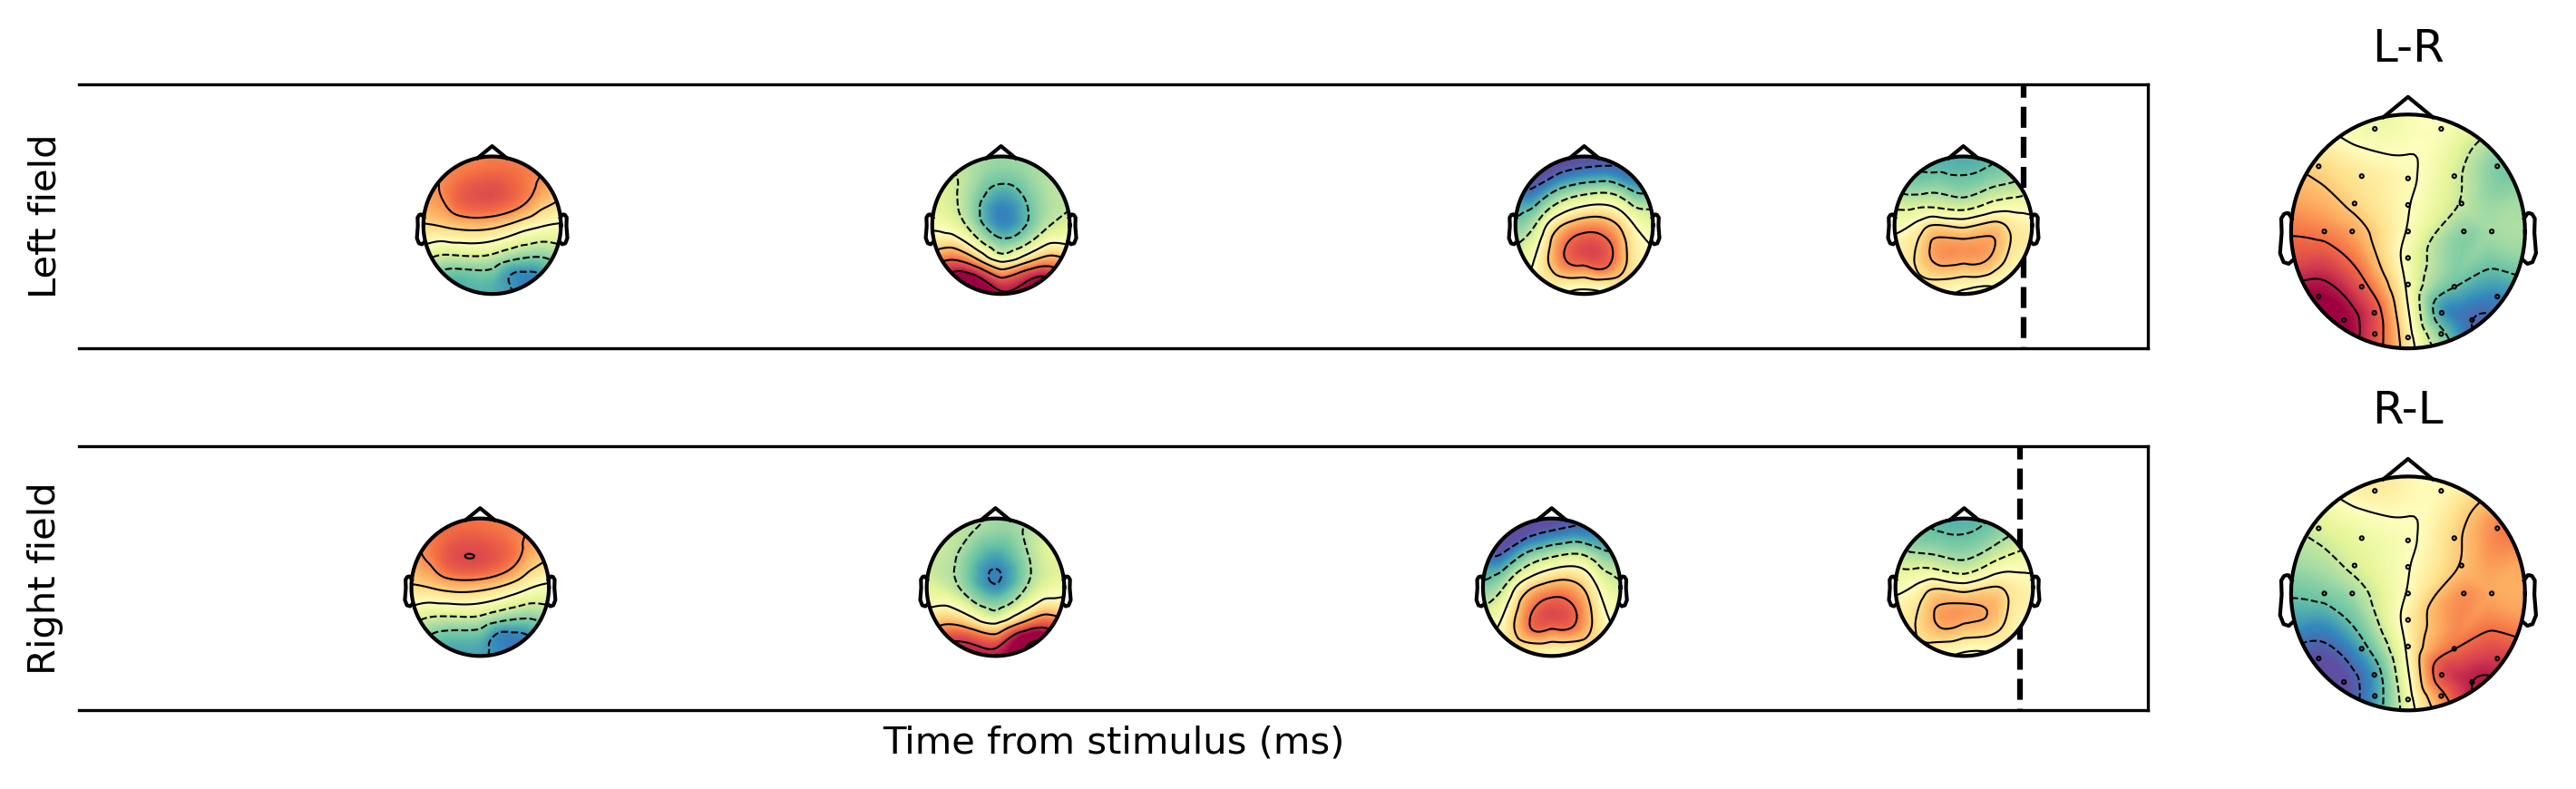

In [2]:
fig = plt.figure(figsize=(10, 3), dpi=300)
gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[1, 0])
ax0 = fig.add_subplot(gs[0, 0], sharex=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

ax_sp = hmp.visu.plot_topo_timecourse(epoch_data, fit_left, epochs.info, init_left, as_time=True, ax=ax0, event_lines=None, 
                                      max_time=600, vmin=-1e-5, vmax=1e-5, colorbar=False)
ax0.set_ylabel('Left field')
ax0.set_xticks([])
ax_acc = hmp.visu.plot_topo_timecourse(epoch_data, fit_right, epochs.info, init_right, as_time=True, ax=ax1, event_lines=None, 
                                       max_time=600, vmin=-1e-5, vmax=1e-5, colorbar=False)
ax1.set_ylabel('Right field')
ax1.set_xlabel('Time from stimulus (ms)')

ax2.set_title('L-R')
ax3.set_title('R-L')

diffLR = mne.viz.plot_topomap(init_left.compute_topologies(epoch_data, fit_left, init_left)[1] - 
                              init_right.compute_topologies(epoch_data, fit_right, init_right)[1], 
                              epochs.info, axes=ax2, show=False, sensors=True, cmap='Spectral_r')

diffRL = mne.viz.plot_topomap(init_right.compute_topologies(epoch_data, fit_right, init_right)[1] - 
                              init_left.compute_topologies(epoch_data, fit_left, init_left)[1], 
                              epochs.info, axes=ax3, show=False, sensors=True, cmap='Spectral_r')

plt.tight_layout()
plt.savefig('HMP_solution_N2pc.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


In [3]:
#Fitting one model for N2pc compariosn with following dataset
init = hmp.models.hmp(hmp_data)
fit = init.fit(tolerance=1e-6, pval=.05)
init.compute_topologies(epoch_data, fit, init, mean=True)[1].to_netcdf("N2pc_topo.nc")

  0%|          | 0/144 [00:00<?, ?it/s]

Transition event 1 found around sample 31
Transition event 2 found around sample 79
Transition event 3 found around sample 127
Transition event 4 found around sample 138

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [4]:
init_left.compute_topologies(epoch_data, fit_left, init_left).sel(event=1).idxmax()

<xarray.DataArray 'channels' ()> Size: 8B
array('PO7', dtype=object)
Coordinates:
    event    int64 8B 1

In [5]:
init_right.compute_topologies(epoch_data, fit_right, init_right).sel(event=1).idxmax()

<xarray.DataArray 'channels' ()> Size: 8B
array('PO8', dtype=object)
Coordinates:
    event    int64 8B 1

In [6]:
#RE-importing data for ERP plot on the full epoch
epoch_data = hmp.utils.read_mne_data(subj_files,epoched=True, scale=1,
                                     verbose=False, ignore_rt=True)


Processing participant N2pc_data/7_reref_epo.fif's epoched eeg
8 trials were retained for participant N2pc_data/7_reref_epo.fif
Processing participant N2pc_data/26_reref_epo.fif's epoched eeg
219 trials were retained for participant N2pc_data/26_reref_epo.fif
Processing participant N2pc_data/34_reref_epo.fif's epoched eeg
269 trials were retained for participant N2pc_data/34_reref_epo.fif
Processing participant N2pc_data/16_reref_epo.fif's epoched eeg
290 trials were retained for participant N2pc_data/16_reref_epo.fif
Processing participant N2pc_data/8_reref_epo.fif's epoched eeg
241 trials were retained for participant N2pc_data/8_reref_epo.fif
Processing participant N2pc_data/40_reref_epo.fif's epoched eeg
264 trials were retained for participant N2pc_data/40_reref_epo.fif
Processing participant N2pc_data/24_reref_epo.fif's epoched eeg
283 trials were retained for participant N2pc_data/24_reref_epo.fif
Processing participant N2pc_data/22_reref_epo.fif's epoched eeg
237 trials were re

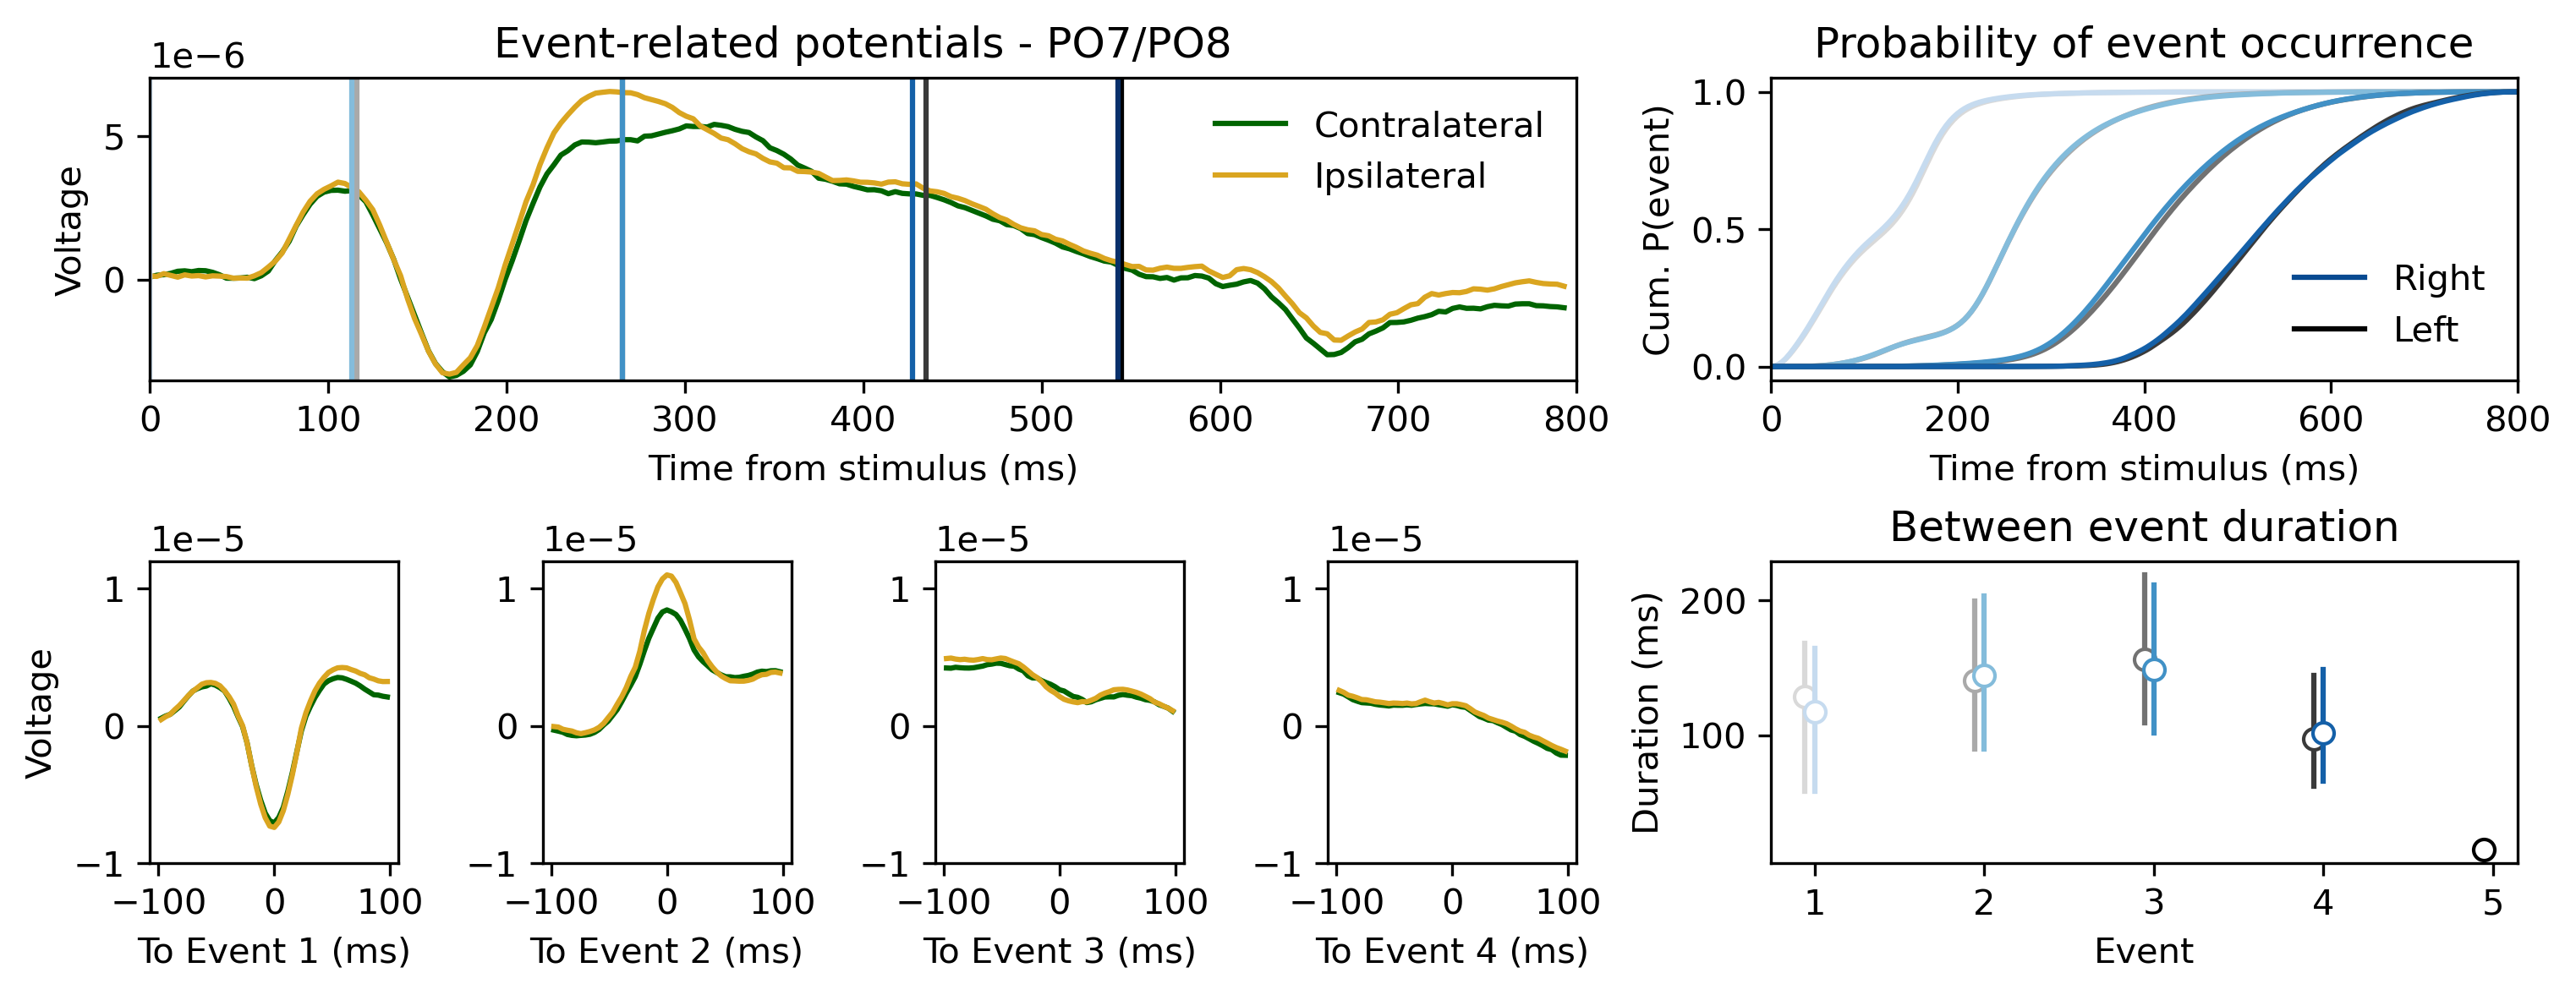

In [7]:
color_cond = {'right':plt.cm.Blues(.9),'left':plt.cm.Greys(.99)}
color_erp = {'ipsi':'goldenrod','contra':'darkgreen'}
fig = plt.figure(constrained_layout=True, figsize=(12, 5), dpi=300)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
tstep = 1000/epochs.info['sfreq']

probs_mean_left = fit_left.eventprobs.mean('trial_x_participant')
probs_mean_right = fit_right.eventprobs.mean('trial_x_participant')
color_ev_right = {i: plt.cm.Blues(x) for i,x in enumerate(np.linspace(.25,1, probs_mean_left.shape[-1]+1))}
color_ev_left = {i: plt.cm.Greys(x) for i,x in enumerate(np.linspace(.25,1, probs_mean_left.shape[-1]+1))}
color_cond_ev = {'right':color_ev_right,'left':color_ev_left}

times_right = init_right.compute_times(init_right, fit_right, fill_value=0, add_rt=True)
times_left = init_left.compute_times(init_left, fit_left, fill_value=0, add_rt=True)
data = epoch_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
mean_times_left = times_left.mean('trial_x_participant')
mean_times_right = times_right.mean('trial_x_participant')


ax1 = fig.add_subplot(gs[0, :4])

# Plotting the single trial aligned events
baseline, n_samples = -25, 25
for i, event in enumerate(times_left.event[1:-1]):
    ax = fig.add_subplot(gs[1, i])
    contraL = hmp.utils.centered_activity(data, times_left, ["PO8"], event=event, baseline=baseline, n_samples=n_samples).data.unstack().mean(['trials', 'channel', 'participant'])
    contraR = hmp.utils.centered_activity(data, times_right, ["PO7"], event=event, baseline=baseline, n_samples=n_samples).data.unstack().mean(['trials', 'channel', 'participant'])
    ax.plot(contraL.samples*tstep, ((contraL + contraR)/2).data, color=color_erp['contra'])
    ipsiL = hmp.utils.centered_activity(data, times_left, ["PO7"], event=event, baseline=baseline, n_samples=n_samples).data.unstack().mean(['trials', 'channel', 'participant'])
    ipsiR = hmp.utils.centered_activity(data, times_right, ["PO8"], event=event, baseline=baseline, n_samples=n_samples).data.unstack().mean(['trials', 'channel', 'participant'])
    ax.plot(ipsiL.samples*tstep, ((ipsiL + ipsiR)/2).data, color=color_erp['ipsi'])
    ax.set_ylim(-1e-5,1.2e-5)
    ax.set_xlabel(f'To Event {event.values} (ms)')
    if i == 0:
        ax.set_ylabel("Voltage")


contraL = hmp.utils.centered_activity(data, times_left, ["PO8"], event=0, n_samples=256, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])
contraR = hmp.utils.centered_activity(data, times_right, ["PO7"], event=0, n_samples=256, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])
ax1.plot(contraL.samples*tstep, ((contraL + contraR)/2).data, color=color_erp['contra'], label='Contralateral')

ipsiR = hmp.utils.centered_activity(data, times_right, ["PO8"], event=0, n_samples=256, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])
ipsiL = hmp.utils.centered_activity(data, times_left, ["PO7"], event=0, n_samples=256, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])
ax1.plot(ipsiL.samples*tstep, ((ipsiL + ipsiR)/2).data, color=color_erp['ipsi'], label='Ipsilateral')
ax1.set_ylim(-3.5e-6, 7e-6)
ax1.set_xlim(0, 800)
ax1.set_xlabel('Time from stimulus (ms)')
ax1.set_ylabel('Voltage')
ax1.set_title('Event-related potentials - PO7/PO8')
ax1.legend(loc="upper right", frameon=False)

durations_left = init_left.compute_times(init_left, fit_left, duration=True, mean=False, add_rt=True).T
times_left = init_left.compute_times(init_left, fit_left, duration=False, mean=False, add_rt=True).T
durations_right = init_right.compute_times(init_right, fit_right, duration=True, mean=False, add_rt=True).T
times_right = init_right.compute_times(init_right, fit_right, duration=False, mean=False, add_rt=True).T
estim_n_events = len(times_left.event[:-1])

for i in range(estim_n_events + 1):
    ax1.vlines(mean_times_left[i]*tstep, -1, 1, color=color_cond_ev['left'][i])
    ax1.vlines(mean_times_right[i]*tstep, -1, 1, color=color_cond_ev['right'][i])

ax2_0 = fig.add_subplot(gs[0, 4])
for i in range(estim_n_events):
    ax2_0.plot(probs_mean_left[:, i].samples*tstep, np.cumsum(probs_mean_left[:, i]), color=color_cond_ev['left'][i])
    ax2_0.plot(probs_mean_right[:, i].samples*tstep, np.cumsum(probs_mean_right[:, i]), color=color_cond_ev['right'][i])
ax2_0.set_ylabel('Cum. P(event)')
ax2_0.set_xlabel('Time from stimulus (ms)')
ax2_0.set_xlim(0, 800)
ax2_0.set_title('Probability of event occurrence')


ax2_1 = fig.add_subplot(gs[1, 4])
for i in range(estim_n_events + 1):
    ax2_1.plot(np.repeat(i + 1, 2) - .055, np.percentile(durations_left[i, :].T, q=[25, 75])*tstep, color=color_cond_ev['left'][i])
    ax2_1.plot(i + 1 - .055, np.percentile(durations_left[i, :].T, q=[50])*tstep, 'o', markerfacecolor='w', markeredgecolor=color_cond_ev['left'][i])
ax2_0.plot([], [], '-', color=color_cond['right'], label='Right')
ax2_0.plot([], [], '-', color=color_cond['left'], label='Left')
ax2_0.legend(loc="lower right", frameon=False)
for i in range(estim_n_events):
    ax2_1.plot(np.repeat(i + 1, 2), np.percentile(durations_right[i, :].T, q=[25, 75])*tstep, color=color_cond_ev['right'][i])
    ax2_1.plot(i + 1, np.percentile(durations_right[i, :].T, q=[50])*tstep, 'o', markerfacecolor='w', markeredgecolor=color_cond_ev['right'][i])

ax2_1.set_xlabel('Event')
ax2_1.set_ylabel('Duration (ms)')
ax2_1.set_title('Between event duration')
plt.savefig('HMP_plot_N2pc.png',dpi=300,transparent=True,bbox_inches='tight')

plt.show()

In [8]:
all_elec_right = init_right.compute_topologies(epoch_data,fit_right,init_right, mean=False)
right = all_elec_right.sel(channels='PO8').to_dataframe(name='peak').peak - all_elec_right.sel(channels='PO7').to_dataframe(name='peak').peak
all_elec_left = init_left.compute_topologies(epoch_data,fit_left,init_left, mean=False)
left = all_elec_left.sel(channels='PO7').to_dataframe(name='peak').peak -  all_elec_left.sel(channels='PO8').to_dataframe(name='peak').peak

peak = pd.concat([right.reset_index(),left.reset_index()])
peak.reset_index(drop=True, inplace=True)
peak.peak /= 1e-6
peak

,participant,trials,event,peak
0,S0,8,0,9.907282
1,S0,8,1,8.543985
2,S0,8,2,19.665048
3,S0,8,3,-23.451761
4,S0,24,0,21.166144
...,...,...,...,...
36395,S39,289,3,-0.636170
36396,S39,295,0,8.941780
36397,S39,295,1,7.943516
36398,S39,295,2,0.044337


In [9]:
peak_model = bmb.Model("peak ~ 0 + event + (0+event | participant) ", peak, family="gaussian", 
                        categorical='event', dropna=True)
results = peak_model.fit()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [peak_sigma, event, event|participant_sigma, event|participant_offset]


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x727ddb814710>>
Traceback (most recent call last):
  File "/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
az.summary(results, hdi_prob=.95, var_names=list(results.posterior.data_vars.keys())[:3])

In [ ]:
hmp.visu.plot_topo_timecourse(

# 